In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import os
import scipy
from multiprocessing import Queue
#from google.colab import drive
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import * 
from tensorflow.keras.applications import *
from tensorflow.keras.callbacks import *
from tensorflow.keras.initializers import *


#drive.mount('/content/drive')
# Set the random seed
np.random.seed(1337)


In [ ]:
# help from https://medium.com/analytics-vidhya/predict-artist-from-art-using-deep-learning-9f465f8879d7
batch_size = 20
t_in_shape = (100,100,3)

# doing roughly 0.8:0.1:0.1 train:valid:test split
# test is roughly 0.1 the original dataset size
train_datagen = ImageDataGenerator(validation_split=0.1,
                                   rescale=1./255.,
                                   shear_range=5,
                                   horizontal_flip=True,
                                   vertical_flip=False)
test_datagen = ImageDataGenerator(rescale=1./255.)
train_generator = train_datagen.flow_from_directory(directory='./painting_styles',
                                                    class_mode='categorical',
                                                    target_size=t_in_shape[0:2],
                                                    batch_size=batch_size,
                                                    subset="training",
                                                    shuffle=True)
valid_generator = train_datagen.flow_from_directory(directory='./painting_styles',
                                                    class_mode='categorical',
                                                    target_size=t_in_shape[0:2],
                                                    batch_size=batch_size,
                                                    subset="validation",
                                                    shuffle=True)
test_generator = test_datagen.flow_from_directory(directory='./styles_test',
                                                  class_mode='categorical',
                                                  target_size=t_in_shape[0:2],
                                                  batch_size=batch_size,
                                                  shuffle=True)

step_train = train_generator.n//train_generator.batch_size
step_valid = valid_generator.n//valid_generator.batch_size

Found 3530 images belonging to 16 classes.
Found 385 images belonging to 16 classes.
Found 435 images belonging to 16 classes.


In [ ]:
base_model = ResNet50(include_top=False, input_shape=t_in_shape)

In [ ]:
X = base_model.output
X = Flatten()(X)
X = Dense(512, kernel_initializer='he_uniform')(X)
X = BatchNormalization()(X)
X = Activation('relu')(X)
X = Dense(16, kernel_initializer='he_uniform')(X)
X = Activation('relu')(X)
out = Dense(16, activation='softmax')(X)

model = Model(inputs=base_model.input, outputs = out)

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.0001),
             metrics=['accuracy'])

In [ ]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1,
                              patience=5, verbose=1)
history = model.fit(train_generator, steps_per_epoch=step_train,
                    validation_data=valid_generator, epochs=10,
                    validation_steps=step_valid, callbacks=[reduce_lr],
                    use_multiprocessing=False)

Epoch 1/10
176/176 [==============================] - 69s 334ms/step - loss: 2.0576 - accuracy: 0.3661 - val_loss: 12.3404 - val_accuracy: 0.0632 - lr: 1.0000e-04
Epoch 2/10
176/176 [==============================] - 55s 314ms/step - loss: 1.2971 - accuracy: 0.6405 - val_loss: 16.2949 - val_accuracy: 0.1026 - lr: 1.0000e-04
Epoch 3/10
176/176 [==============================] - 55s 313ms/step - loss: 0.9360 - accuracy: 0.7416 - val_loss: 4.4049 - val_accuracy: 0.0316 - lr: 1.0000e-04
Epoch 4/10
176/176 [==============================] - 55s 313ms/step - loss: 0.6995 - accuracy: 0.8051 - val_loss: 3.5345 - val_accuracy: 0.1395 - lr: 1.0000e-04
Epoch 5/10
176/176 [==============================] - 54s 308ms/step - loss: 0.4774 - accuracy: 0.8670 - val_loss: 2.3440 - val_accuracy: 0.4237 - lr: 1.0000e-04
Epoch 6/10
176/176 [==============================] - 54s 306ms/step - loss: 0.3977 - accuracy: 0.8883 - val_loss: 1.6826 - val_accuracy: 0.6053 - lr: 1.0000e-04
Epoch 7/10
176/176 [======

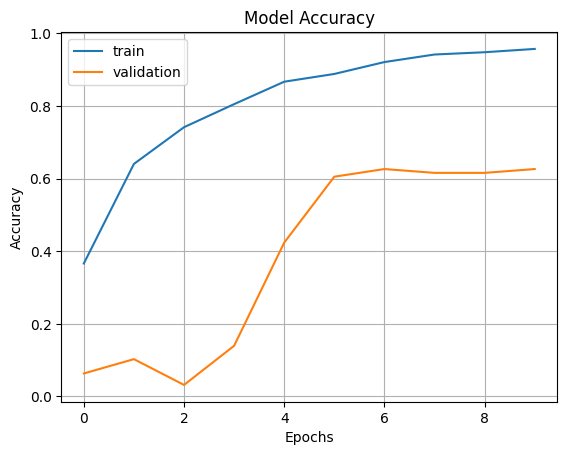

In [ ]:
fig1 = plt.gcf()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.grid()
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train','validation'])
plt.show()

In [ ]:
score = model.evaluate(test_generator)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

22/22 [==============================] - 5s 241ms/step - loss: 1.5461 - accuracy: 0.6414
Test loss: 1.546137809753418
Test accuracy: 0.6413792967796326
